In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as plt

# Exercise 1

In [168]:
data = []

pedago_period = [249108, 942175]
semesters = ['semester 1', 'semester 6']
acad_period = [978181, 978187, 978195, 39486325, 123455150, 123456101, 213637754, 213637922, 213638028, 355925344]
years = ['2007-2008','2008-2009','2009-2010', '2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017']

for pedago in pedago_period:
    for acad in acad_period:
        payload = {'ww_x_GPS': '-1',
                   'ww_i_reportModel': 133685247,
                   'ww_i_reportModelXsl': 133685270,
                   'ww_x_UNITE_ACAD': 249847,
                   'ww_x_PERIODE_ACAD': acad,
                   'ww_x_PERIODE_PEDAGO': pedago,
                   'ww_x_HIVERETE': 'null'
                  }
        data.append(requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html', params=payload))

In [169]:
soups = []
for i in range(0, 20):
    soups.append(BeautifulSoup(data[i].text, 'html.parser'))

In [170]:
from math import floor

students = []
i = 0
for fsoup in soups:
    for tr in fsoup.html.body.hr.table.findAll('tr'):
        tds = tr.findAll('td')
        if (len(tds) > 0):
            student = {'civilite': tds[0].text,
                       'name': tds[1].text,
                       'sciper': tds[10].text,
                       'year': years[i%10],
                       'semester': semesters[floor(i/10)]
                      }
            students.append(student)
    i += 1
    if (i == 10):
        students_sem1 = pd.DataFrame(students)
        students = []
    elif (i == 20):
        students_sem6 = pd.DataFrame(students)

students_sem6.drop('civilite', axis=1, inplace=True)
students_sem6.drop('name', axis=1, inplace=True)

students_sem1.drop_duplicates(subset=['sciper'], keep='first', inplace=True)
students_sem1.set_index(['sciper'], inplace=True)

students_sem6.drop_duplicates(subset=['sciper'], keep='last', inplace=True)
students_sem6.set_index(['sciper'], inplace=True)

students = pd.concat([students_sem1, students_sem6], axis=1, join='inner')
students.drop('semester', axis=1, inplace=True)
students.columns = ['civilite', 'name', 'arrival year', 'graduation year']

students['duration'] = [int(dep.split("-")[1]) - int(arr.split("-")[0]) for arr, dep in students[['arrival year', 'graduation year']].values]
students['duration'] *= 10

students.head()

,civilite,name,arrival year,graduation year,duration
sciper,,,,,
169569,Monsieur,Arévalo Christian,2007-2008,2009-2010,30
179449,Monsieur,Bindschaedler Vincent,2007-2008,2009-2010,30
178553,Monsieur,Bloch Marc-Olivier,2007-2008,2009-2010,30
178271,Monsieur,Boéchat Marc-Alexandre,2007-2008,2009-2010,30
180731,Monsieur,Bricola Jean-Charles,2007-2008,2009-2010,30


In [171]:
students.sort_values('civilite', ascending=1)
students['civilite'].value_counts(normalize=True, sort=True, ascending=True)

Madame      0.073048
Monsieur    0.926952
Name: civilite, dtype: float64

As we can notice (even in master) there is a huge minority of women in computer science 

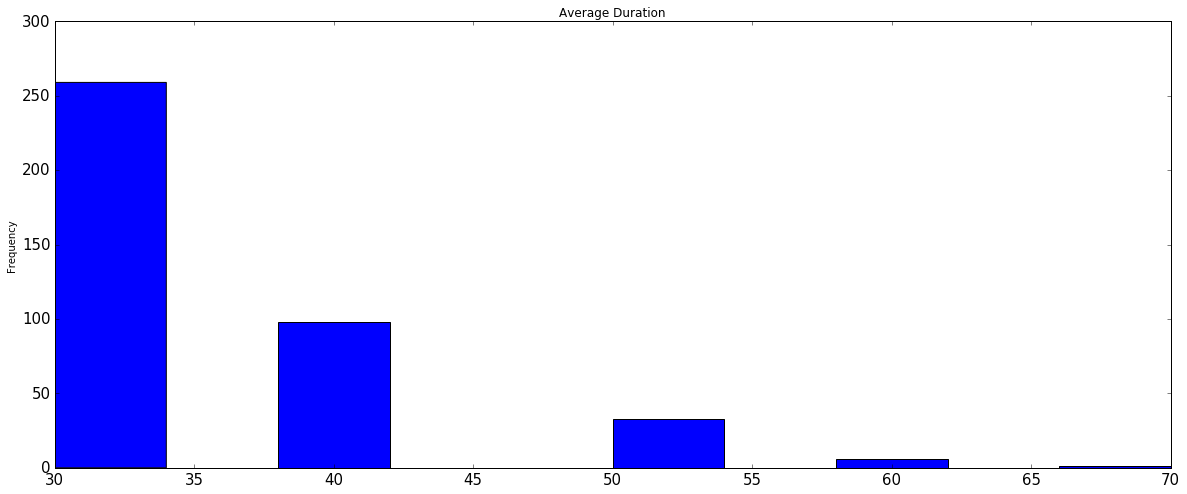

In [172]:
plt.figure(figsize=(20,8))
students['duration'].plot(kind ='hist',fontsize =15,title ='Average Duration')

In [173]:
averageDuration_students_femal = students[students['civilite']== 'Madame']['duration'].mean()
averageDuration_students_mal = students[students['civilite']== 'Monsieur']['duration'].mean()

In [174]:
students['sex'] = (students['civilite'] == 'Monsieur').astype(int)

In [175]:
import scipy.stats 
obs = np.array([students['sex'], students['duration']])
g, p, dof, expctd = scipy.stats.chi2_contingency(obs)
print('p-value is  : ' , p)

p-value is  :  1.0


In [177]:
As expected, given the high p-value, the test result does not detect a significant relationship between the variables.

SyntaxError: invalid syntax (<ipython-input-177-181344bf7438>, line 1)

In [176]:
rvs1 = students[students['civilite']== 'Madame']['duration']
rvs2 = students[students['civilite']== 'Monsieur']['duration']
stats.ks_2samp(rvs1, rvs2)


Ks_2sampResult(statistic=0.077398800599700168, pvalue=0.99572515917079174)

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.
This is the two-sided test, one-sided tests are not implemented. The test uses the two-sided asymptotic Kolmogorov-Smirnov distribution.




# Exercise 2

In [10]:
# define the parameters :
#TODO : import datas, each year, each semester
# Idea join by sciper : without inner :/

#semester = [2230106, 942192, 2230128, 249127, 3781783]
#semester_names = ['master 1', 'master 2', 'master 3', 'master project autumn','master project spring']

#acad_period = [978181, 978187, 978195, 39486325, 123455150, 123456101, 213637754, 213637922, 213638028, 355925344]
#acad_period_names = ['2007-2008','2008-2009','2009-2010', '2010-2011', '2011-2012', '2012-2013', 
#                      '2013-2014', '2014-2015', '2015-2016', '2016-2017']

#semesters = {
#    'master1': 2230106,
#    'master2': 942192,
#    'master3': 2230128,
#    'project_autumn': 249127,
#    'project_spring': 3781783
#}

First we create 2 dictionaries that associate the request's code of each kind of semester to their nomination and the same for academic years.

Moreover, to create a kind of bijection between the name and the code, we create a function getCode.

In [11]:
all_semesters = {
    2230106: 'master1',
    942192: 'master2',
    2230128: 'master3',
    249127: 'project_autumn',
    3781783: 'project_spring'
}

all_years = {
    978181: '2007-2008',
    978187: '2008-2009',
    978195: '2009-2010',
    39486325: '2010-2011',
    123455150: '2011-2012',
    123456101: '2012-2013',
    213637754: '2013-2014',
    213637922: '2014-2015',
    213638028: '2015-2016',
    355925344: '2016-2017'
}

def getCode(dictionary, value):
    for code, name in dictionary.items():
        if name == value:
            return code

Now we define a function that returns the beautifulsoup HTML file with all the students registered in the year and the semester given in parameters.

In [12]:
def getRawData(year, sem):
    payload = {'ww_x_GPS': '-1',
               'ww_i_reportModel': 133685247,
               'ww_i_reportModelXsl': 133685270,
               'ww_x_UNITE_ACAD': 249847,
               'ww_x_PERIODE_ACAD': year,
               'ww_x_PERIODE_PEDAGO': sem,
               'ww_x_HIVERETE': 'null'
              }

    data = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html', params=payload)
    return BeautifulSoup(data.text, 'html.parser')

The next function gets raw data using the previous function and structures them to obtain a list of students. Each student is a dictionary with the following properties: civility, name, sciper, academic year, semester, minor and the specialization.

In [13]:
def getStructuredData(year, sem):
    raw_data = getRawData(year, sem)
    students = []
    
    for tr in raw_data.html.body.hr.table.findAll('tr'):
        tds = tr.findAll('td')
        if (len(tds) > 0):
            student = {
                'civility': tds[0].text,
                'name': tds[1].text,
                'sciper': tds[10].text,
                'academic year': all_years.get(year),
                'semester': all_semesters.get(sem),
                'minor': tds[6].text,
                'specialization': tds[4].text
                }
            students.append(student)
    return students

Now, to make it easy, we create a function "getDataFrame" that returns a pandas dataframe with all the students registered for the years in the list "years" and for the semesters in the list "semesters", both passed in parameters.

In [14]:
def getDataFrame(years, semesters):
    results = []
    
    for year in years:
        for sem in semesters:
            results.extend(getStructuredData(year, sem))
    
    return pd.DataFrame(results)

All the preparation is done, we can collect and use the data:

First step is to get all the student that made a master semester 1, 2 and 3. We store these students in 3 different dataframes student_ma1, student_ma2 and student_ma3.

In [15]:
# ==================================================================================
# /!\ Quite slow to get the data, so try to not execute this cell too many times /!\
# ==================================================================================

student_ma1 = getDataFrame(all_years, [getCode(all_semesters, 'master1')])
student_ma2 = getDataFrame(all_years, [getCode(all_semesters, 'master2')])
student_ma3 = getDataFrame(all_years, [getCode(all_semesters, 'master3')])
student_maP_aut = getDataFrame(all_years, [getCode(all_semesters, 'project_autumn')])
student_maP_spr = getDataFrame(all_years, [getCode(all_semesters, 'project_spring')])


Let's start to manage data:
In order to have a better view of the data, we sort them by the academic year in our 3 dataframes.

In [16]:
student_ma1.sort_values('academic year', inplace=True)
student_ma2.sort_values('academic year', inplace=True)
student_ma3.sort_values('academic year', inplace=True)
student_maP_aut.sort_values('academic year', inplace=True)
student_maP_spr.sort_values('academic year', inplace=True)

Sometimes a student can do the "master semester 1" more than once, if he fails its year and restart it the year after. In this case, we only want to keep the first "master semester 1" that he did here. Indeed, we want to compute the total time he spent at the EPFL.
But for the two other dataframes, we want the opposite: keeping the last semester the student did here.

In [17]:
student_ma1.drop_duplicates(subset=['sciper'], keep='first', inplace=True)
student_ma2.drop_duplicates(subset=['sciper'], keep='last', inplace=True)
student_ma3.drop_duplicates(subset=['sciper'], keep='last', inplace=True)

# unique sciper for aut un spr


Now we can use the sciper number as index because it should be unique for each dataframe. It is going to be useful to make the concatenation.

In [18]:
student_ma1.set_index('sciper', inplace=True)
student_ma2.set_index('sciper', inplace=True)
student_ma3.set_index('sciper', inplace=True)
student_maP_aut.set_index('sciper', inplace=True)
student_maP_spr.set_index('sciper', inplace=True)

The goal being to find the duration spent at the EPFL for each student, we have to clean a little bit the dataframes.

We make the assumption that if a student chose a minor or a specialization in the semester 1, this minor/specialization will still be present for him in the semester 2. So we can drop those 2 columns in the student_ma1 dataframe.
Likewise, we can drop the columns name and civility in the student_ma2.

In [19]:
student_ma1.drop('minor', axis=1, inplace=True)
student_ma1.drop('specialization', axis=1, inplace=True)
student_ma1.drop('semester', axis=1, inplace=True)

student_ma2.drop('civility', axis=1, inplace=True)
student_ma2.drop('name', axis=1, inplace=True)
student_ma2.drop('semester', axis=1, inplace=True)

student_ma3.drop('civility', axis=1, inplace=True)
student_ma3.drop('name', axis=1, inplace=True)
student_ma3.drop('specialization', axis=1, inplace=True)
student_ma3.drop('minor', axis=1, inplace=True)
student_ma3.drop('semester', axis=1, inplace=True)


student_maP_spr.drop('civility', axis=1, inplace=True)
student_maP_spr.drop('name', axis=1, inplace=True)
student_maP_spr.drop('specialization', axis=1, inplace=True)
student_maP_spr.drop('minor', axis=1, inplace=True)
student_maP_spr.drop('semester', axis=1, inplace=True)


student_maP_aut.drop('civility', axis=1, inplace=True)
student_maP_aut.drop('name', axis=1, inplace=True)
student_maP_aut.drop('specialization', axis=1, inplace=True)
student_maP_aut.drop('minor', axis=1, inplace=True)
student_maP_aut.drop('semester', axis=1, inplace=True)


To display it properly, let's rename the columns before concatenating master 1 and master 2 dataframes and reordering their columns.

In [20]:
student_ma1.columns = ['semester 1', 'civility', 'name']
student_ma2.columns = ['semester 2', 'minor', 'specialization']
student_ma3.columns = ['semester 3']
student_maP_aut.columns = ['project aut']
student_maP_spr.columns = ['project spr']


students = pd.concat([student_ma1, student_ma2], axis=1, join="inner")
students = pd.concat([students,student_ma3] , axis = 1)
students = pd.concat([students,student_maP_aut] , axis = 1)
students = pd.concat([students,student_maP_spr] , axis = 1)
students = students[['civility', 'name', 'semester 1', 'semester 2','semester 3','project aut','project spr', 'minor', 'specialization']]
students.dropna(subset = ['civility'] , inplace = True)
students.fillna(value='',inplace = True)
students


,civility,name,semester 1,semester 2,semester 3,project aut,project spr,minor,specialization
146330,Monsieur,Cardinaux Damien,2007-2008,2007-2008,2008-2009,,,,
146742,Monsieur,Marx Clément,2008-2009,2009-2010,2012-2013,2010-2011,2010-2011,,"Signals, Images and Interfaces"
146929,Monsieur,Junod Antoine,2007-2008,2007-2008,,,,,
147008,Monsieur,Good Xavier,2011-2012,2012-2013,2012-2013,,,,
152232,Monsieur,Anagnostaras David,2007-2008,2007-2008,2008-2009,,,"Mineur en Management, technologie et entrepren...",
153066,Monsieur,Aeberhard François-Xavier,2007-2008,2009-2010,2009-2010,,,,Internet computing
153746,Monsieur,Cassina Ilya,2007-2008,2007-2008,,,,,
153762,Monsieur,Conus Johann,2008-2009,2009-2010,2009-2010,,,,
154080,Monsieur,Fomene Tierry Alain,2007-2008,2008-2009,2009-2010,,,,Internet computing
154573,Madame,Benabdallah Zeineb,2007-2008,2008-2009,2009-2010,,2009-2010,,Biocomputing


In [83]:
students['duration'] = [int(dep.split("-")[1]) - int(arr.split("-")[0]) 
                        for arr, dep in students[['semester 1', 'semester 2']].values]
for i,row in students.iterrows() : 
    if (row['semester 3'] != '') :
        students.loc[i,'duration'] += 0.5
    elif ((row['minor'] != '' or row['specialization'] != '')) : 
        students.loc[i,'duration']  +=0.5
    if (row['project aut'] != '') :
        students.loc[i,'duration'] += 0.5     
    if (row['project spr'] != '') :
        students.loc[i,'duration'] += 0.5
    if (row['project spr'] == '' and row['project aut'] == '' ) :
        students.loc[i,'duration'] += 0.5
    
#     # somme guys started with semester 2 :/
#     students[students['duration'] == 0.5]

students

,civility,name,semester 1,semester 2,semester 3,project aut,project spr,minor,specialization,duration
146330,Monsieur,Cardinaux Damien,2007-2008,2007-2008,2008-2009,,,,,2.0
146742,Monsieur,Marx Clément,2008-2009,2009-2010,2012-2013,2010-2011,2010-2011,,"Signals, Images and Interfaces",3.5
146929,Monsieur,Junod Antoine,2007-2008,2007-2008,,,,,,1.5
147008,Monsieur,Good Xavier,2011-2012,2012-2013,2012-2013,,,,,3.0
152232,Monsieur,Anagnostaras David,2007-2008,2007-2008,2008-2009,,,"Mineur en Management, technologie et entrepren...",,2.0
153066,Monsieur,Aeberhard François-Xavier,2007-2008,2009-2010,2009-2010,,,,Internet computing,4.0
153746,Monsieur,Cassina Ilya,2007-2008,2007-2008,,,,,,1.5
153762,Monsieur,Conus Johann,2008-2009,2009-2010,2009-2010,,,,,3.0
154080,Monsieur,Fomene Tierry Alain,2007-2008,2008-2009,2009-2010,,,,Internet computing,3.0
154573,Madame,Benabdallah Zeineb,2007-2008,2008-2009,2009-2010,,2009-2010,,Biocomputing,3.0


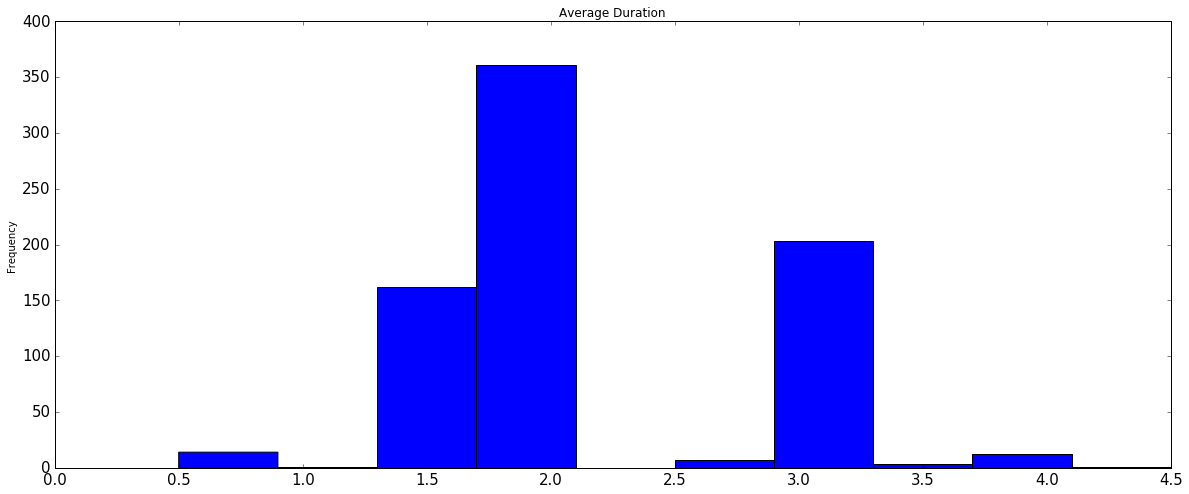

In [150]:
plt.figure(figsize=(20,8))
students['duration'].plot(kind ='hist',title ='Average Duration', fontsize =15)


In [85]:
# compute the average + #compute for specialisation + gender study
averageDuration_students_femal = students[students['civility']== 'Madame']['duration'].mean()
averageDuration_students_mal = students[students['civility']== 'Monsieur']['duration'].mean()
averageDuration_students = students['duration'].mean()


In [86]:
print('in general the avecrage duration is : ' , averageDuration_students)
print('for women the average duration is :',averageDuration_students_femal)
print('for men the avecrage duration is : ' , averageDuration_students_mal)

in general the avecrage duration is :  2.1760471204188483
for women the average duration is : 2.217821782178218
for men the avecrage duration is :  2.169683257918552


In [95]:
students_with_specialization=students[students['specialization'] != ''].sort_values('specialization')
students_with_specialization.head(180)

,civility,name,semester 1,semester 2,semester 3,project aut,project spr,minor,specialization,duration
154573,Madame,Benabdallah Zeineb,2007-2008,2008-2009,2009-2010,,2009-2010,,Biocomputing,3.0
169734,Monsieur,Koller Yannick,2007-2008,2008-2009,2009-2010,,,,Biocomputing,3.0
224627,Monsieur,Bloch Aurélien François Gilbert,2015-2016,2015-2016,2016-2017,,,,Computer Engineering - SP,2.0
178271,Monsieur,Boéchat Marc-Alexandre,2010-2011,2010-2011,2011-2012,,,,Computer Engineering - SP,2.0
223825,Monsieur,Vassor Martin Thomas,2015-2016,2015-2016,2016-2017,,,,Computer Engineering - SP,2.0
178283,Monsieur,Brunet Yorick,2009-2010,2009-2010,2010-2011,,,,Computer Engineering - SP,2.0
217301,Madame,Pignat Eliéva Arlette,2014-2015,2015-2016,2015-2016,2016-2017,,,Computer Engineering - SP,3.0
216690,Monsieur,Roulin Andy,2014-2015,2015-2016,2016-2017,,,,Computer Engineering - SP,3.0
244206,Monsieur,Doy Damien,2015-2016,2015-2016,2016-2017,,,,Computer Engineering - SP,2.0
214225,Monsieur,Depraz Florian Vincent,2014-2015,2015-2016,2016-2017,,,,Computer Engineering - SP,3.0


([<matplotlib.axis.XTick at 0x2406cdcd748>,
 <a list of 9 Text xticklabel objects>)

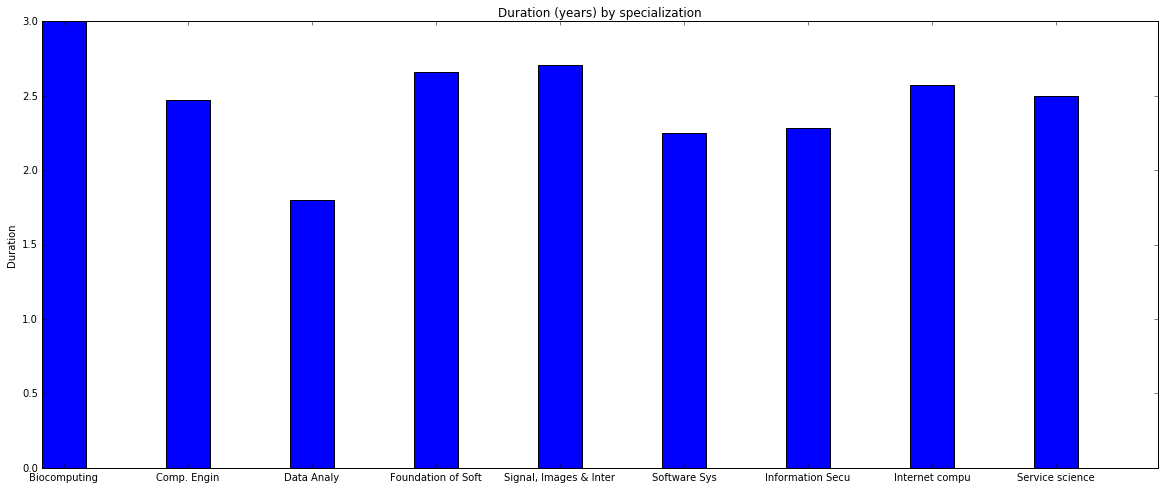

In [155]:
import matplotlib.pyplot as plt
N = 9
Means = (students_with_specialization[students_with_specialization['specialization'] == 'Biocomputing']['duration'].mean(),
students_with_specialization[students_with_specialization['specialization'] == 'Computer Engineering - SP']['duration'].mean(),
students_with_specialization[students_with_specialization['specialization'] == 'Data Analytics']['duration'].mean(),
students_with_specialization[students_with_specialization['specialization'] == 'Foundations of Software']['duration'].mean(),
students_with_specialization[students_with_specialization['specialization'] == 'Signals, Images and Interfaces']['duration'].mean(),
students_with_specialization[students_with_specialization['specialization'] == 'Software Systems']['duration'].mean(),
students_with_specialization[students_with_specialization['specialization'] == 'Information Security - SP']['duration'].mean(),
students_with_specialization[students_with_specialization['specialization'] == 'Internet computing']['duration'].mean(),
students_with_specialization[students_with_specialization['specialization'] == 'Service science']['duration'].mean())

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(20,8))
plt.bar(ind, Means, width, color='b')

plt.ylabel('Duration')
plt.title('Duration (years) by specialization')
plt.xticks(ind + width/2., ('Biocomputing', 'Comp. Engin', 'Data Analy', 'Foundation of Soft',
                            'Signal, Images & Inter','Software Sys','Information Secu','Internet compu','Service science'))

In [166]:
from scipy import stats
rvs1 = np.array(Means)
rvs2 = np.array(Means).mean()*np.ones(9)
stats.ks_2samp(rvs1, rvs2)


Ks_2sampResult(statistic=0.55555555555555558, pvalue=0.077848349860337257)

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same. 

Biocomputing is harder :D

## Bonus